## Finding differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression
### Utilize Group Lasso with MISIM miRNA similarity data

In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\
    
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

from definitions import ROOT_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load normal and cancer miRNA expression data

In [2]:
from definitions import ROOT_DIR

# Load files into pandas data frames
mirna_tumor_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/tumor_miRNA.csv"))
mirna_normal_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/normal_miRNA.csv"))
clinical_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/clinical/clinical.csv"))
validated_miRNA_csv = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))

# Print data frame shapes
print "mirna_tumor_df.shape", mirna_tumor_df.shape, ', nulls:', mirna_tumor_df.isnull().sum().sum()
print "mirna_normal_df.shape", mirna_normal_df.shape, ', nulls:', mirna_normal_df.isnull().sum().sum()
print 'validated_miRNAs.shape', validated_miRNA_csv.shape

# Merge normal and tumor miRNA expression profiles with clinical cancer stage data
mirna_normal = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_normal_df, on='patient_barcode')
mirna_normal['pathologic_stage'] = 'normal'
mirna_tumor = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_tumor_df, on='patient_barcode')

mirna_tumor.dropna(inplace=True)
mirna_normal.dropna(inplace=True)

# Map stage IA to stage I, IB to I, etc. ...
pathologic_stage_map = {'Stage IA': 'Stage I', 'Stage IB': 'Stage I', 
                        'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 
                        'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III'}
mirna_tumor.replace({'pathologic_stage': pathologic_stage_map}, inplace=True)

# Store list of all miRNA's in miRNA expression data
mirna_list = list(mirna_tumor.columns)[2:]

# Print quick overview of data
print mirna_normal['pathologic_stage'].value_counts().sort_index(axis=0)
print mirna_tumor['pathologic_stage'].value_counts().sort_index(axis=0)

mirna_tumor_df.shape (513, 1882) , nulls: 0
mirna_normal_df.shape (46, 1882) , nulls: 0
validated_miRNAs.shape (34, 2)
normal    46
Name: pathologic_stage, dtype: int64
Stage I      277
Stage II     121
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64


## Load normal & cancer Gene Expression data

In [3]:
gene_exp_tumor_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/processed/gene_expression/tumor/READ__illuminahiseq_rnaseqv2__GeneExp.txt'), 
                                      header=0, delimiter='\t')
gene_exp_normal_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/processed/gene_expression/normal/READ__illuminahiseq_rnaseqv2__GeneExp.txt'), 
                                      header=0, delimiter='\t')

gene_exp_tumor_df.rename(columns=lambda x: x[:12], inplace=True)
gene_exp_normal_df.rename(columns=lambda x: x[:12], inplace=True)

print gene_exp_tumor_df.shape
print gene_exp_normal_df.shape

(20530, 517)
(20530, 61)


## Reshape gene expression data frames to have shape (patients x gene expression) 

In [4]:
# Remove entries with unknown Gene Symbol
gene_exp_tumor_df = gene_exp_tumor_df[gene_exp_tumor_df.GeneSymbol != '?']
gene_exp_normal_df = gene_exp_normal_df[gene_exp_normal_df.GeneSymbol != '?']

# Get list of all gene_symbols
gene_symbols = list(gene_exp_tumor_df['GeneSymbol'])
# Get list of tumor and normal patient_barcode
gene_exp_tumor_patient_barcodes = list(gene_exp_tumor_df.columns)[2:]
gene_exp_normal_patient_barcodes = list(gene_exp_normal_df.columns)[2:]

# Drop EntrezID column
gene_exp_tumor = gene_exp_tumor_df.drop(['EntrezID', 'GeneSymbol'], axis=1)
gene_exp_normal = gene_exp_normal_df.drop(['EntrezID', 'GeneSymbol'], axis=1)

# Reshaping data frame to have columns for GeneSymbols, and rows of patients
gene_exp_tumor = gene_exp_tumor.T
gene_exp_normal = gene_exp_normal.T
gene_exp_tumor.columns = gene_symbols
gene_exp_normal.columns = gene_symbols

# Add column for patients barcode
gene_exp_tumor['patient_barcode'] = gene_exp_tumor.index
gene_exp_normal['patient_barcode'] = gene_exp_normal.index

print "gene_symbols", len(gene_symbols)
print "gene_exp_tumor_patients", len(gene_exp_tumor_patient_barcodes)
print "gene_exp_normal_patients", len(gene_exp_normal_patient_barcodes)

print gene_exp_tumor.shape
print gene_exp_normal.shape

gene_symbols 20502
gene_exp_tumor_patients 515
gene_exp_normal_patients 59
(515, 20503)
(59, 20503)


## Filter samples with matched Gene Expression data and miRNA data
## More data preprocessing

In [5]:
# Merge normal and tumor miRNA expression profiles with clinical cancer stage data
merged_tumor_patients = pandas.merge(gene_exp_tumor[['patient_barcode']], mirna_tumor, on='patient_barcode')[['patient_barcode', 'pathologic_stage']]
merged_normal_patients = pandas.merge(gene_exp_normal[['patient_barcode']], mirna_normal, on='patient_barcode')[['patient_barcode', 'pathologic_stage']]

# Print quick overview of data
print merged_tumor_patients['pathologic_stage'].value_counts(dropna=False).sort_index(axis=0)
print merged_normal_patients['pathologic_stage'].value_counts(dropna=False).sort_index(axis=0)

# Drop NA
merged_tumor_patients.dropna(inplace=True)
merged_normal_patients.dropna(inplace=True)

# Filter samples
merged_mirna_tumor = mirna_tumor[mirna_tumor['patient_barcode'].isin(merged_tumor_patients['patient_barcode'])]
merged_mirna_normal = mirna_normal[mirna_normal['patient_barcode'].isin(merged_normal_patients['patient_barcode'])]
merged_gene_exp_tumor = gene_exp_tumor[gene_exp_tumor['patient_barcode'].isin(merged_tumor_patients['patient_barcode'])]
merged_gene_exp_normal = gene_exp_normal[gene_exp_normal['patient_barcode'].isin(merged_normal_patients['patient_barcode'])]

# Create label vector
Y = pandas.concat([merged_mirna_tumor, merged_mirna_normal])['pathologic_stage']
Y.replace({'pathologic_stage': {'Stage I': 'tumor', 'Stage II': 'tumor', 'Stage III': 'tumor', 'Stage IV': 'tumor'}}, inplace=True)
n_tumor = merged_mirna_tumor.shape[0]
n_normal = merged_mirna_normal.shape[0]

# Drop categorical columns
merged_mirna_tumor.drop(['patient_barcode', 'pathologic_stage'], 1, inplace=True)
merged_mirna_normal.drop(['patient_barcode', 'pathologic_stage'], 1, inplace=True)
merged_gene_exp_tumor.drop(['patient_barcode'], 1, inplace=True)
merged_gene_exp_normal.drop(['patient_barcode'], 1, inplace=True)

# Drop duplicate columns names (Gene symbols with same name)
_, i = np.unique(merged_gene_exp_tumor.columns, return_index=True)
merged_gene_exp_tumor = merged_gene_exp_tumor.iloc[:, i]
merged_gene_exp_normal = merged_gene_exp_normal.iloc[:, i]

print "merged_mirna_tumor", merged_mirna_tumor.shape, 'nulls:', merged_mirna_tumor.isnull().sum().sum()
print "merged_mirna_normal", merged_mirna_normal.shape, 'nulls:', merged_mirna_normal.isnull().sum().sum()
print "merged_gene_exp_tumor", merged_gene_exp_tumor.shape, 'nulls:', merged_gene_exp_tumor.isnull().sum().sum()
print "merged_gene_exp_normal", merged_gene_exp_normal.shape, 'nulls:', merged_gene_exp_normal.isnull().sum().sum()

Stage I      275
Stage II     120
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64
normal    20
Name: pathologic_stage, dtype: int64


/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

merged_mirna_tumor (503, 1881) nulls: 0
merged_mirna_normal (20, 1881) nulls: 0
merged_gene_exp_tumor (503, 20484) nulls: 0
merged_gene_exp_normal (20, 20484) nulls: 0


## Univariate feature selection via FDR

In [150]:
from sklearn.feature_selection import SelectFdr, f_classif

# Select the p-values for an estimated false discovery rate
# FDR 
# mirna_filter = SelectFdr(f_classif, alpha=0.01)
# mirna_new = mirna_filter.fit_transform(X=pandas.concat([mirna_tumor, mirna_normal]), y=Y)

gene_exp_filter = SelectFdr(f_classif, alpha=0.01)
gen_exp_new = gene_exp_filter.fit_transform(X=pandas.concat([gene_exp_tumor, gene_exp_normal]), y=Y)

print mirna_new.shape
print gen_exp_new.shape
# mirna_tumor = mirna_tumor[mirna_tumor.columns[mirna_filter.get_support(indices=True)]]
# mirna_normal = mirna_normal[mirna_normal.columns[mirna_filter.get_support(indices=True)]]
gene_exp_tumor = gene_exp_tumor[gene_exp_tumor.columns[gene_exp_filter.get_support(indices=True)]]
gene_exp_normal = gene_exp_normal[gene_exp_normal.columns[gene_exp_filter.get_support(indices=True)]]

ValueError: could not convert string to float: TCGA-91-6849

In [6]:
from src.data.make_dataset import TCGA_LUAD
tgca_luad = TCGA_LUAD()

mirna_tumor (506, 1883)
mirna_normal (46, 1883)
gene_tumor (515, 20486)
gene_normal (59, 20486)


## Loading TargetScan database for predicted miRNA-targets interactions

In [7]:
# Load data frame from file
targetScan_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_Predicted_Targets_Info_default_predictions.tsv'), delimiter='\t')
targetScan_family_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_miR_Family_Info.txt'), delimiter='\t')

# Select only homo sapiens miRNA-target pairs
targetScan_df = targetScan_df[targetScan_df["Species ID"] == 9606][["miR Family", "Gene Symbol"]]
targetScan_family_df = targetScan_family_df[targetScan_family_df['Species ID'] == 9606][['miR family', 'MiRBase ID']]

# Use miRBase ID names
targetScan_family_df.rename(columns={'miR family': 'miR Family'}, inplace=True)
targetScan_df = pandas.merge(targetScan_df, targetScan_family_df, how='inner', on="miR Family")
targetScan_df = targetScan_df[["MiRBase ID", "Gene Symbol"]]

# Standardize miRNA names
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.lower()
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.replace("-3p.*|-5p.*", "")
targetScan_df.drop_duplicates(inplace=True)

# Filter miRNA-target pairs to only miRNA's included in miRNA expression data, same for gene targets
targetScan_df = targetScan_df[targetScan_df['MiRBase ID'].isin(mirna_list) & targetScan_df['Gene Symbol'].isin(gene_symbols)]
print targetScan_df.shape

(185330, 2)


## Build miRNA-target relationship network to from putative predicted miRNA-target pairs
## Assign miRNA's to groups from the miRNA-target bipartite graph obtained above
The assumption used is that two miRNA's are in the same group, if they share the same target
If a miRNA has overlapping groups, "larger_groups_first" param decides whether larger or smaller group takes priority

In [8]:
from src.models.miRNA_target_network import miRNATargetNetwork as miRNATargetNet
import networkx as nx

network = miRNATargetNet(dys_threshold=0.6)
# network.train(miRNAs_tumor=merged_mirna_tumor,
#               gene_tumor=merged_gene_exp_tumor,
#               miRNAs_normal=merged_mirna_normal,
#               gene_normal=merged_gene_exp_normal,
#               putative_assocs=targetScan_df)

network.fit(miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor',
                                                  normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor',
                                                normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='normal',
                                                   normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='normal',
                                                 normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=targetScan_df)

# print nx.bipartite.sets(network.B)

n_A 503
n_B 20


src/models/miRNA_target_network.py:51: RuntimeWarning: invalid value encountered in double_scalars
  ((n_B - 1) * np.std(miRNA_B[m]) * np.std(gene_B[t]))


src/models/miRNA_target_network.py:47: RuntimeWarning: invalid value encountered in double_scalars
  ((n_A - 1) * np.std(miRNA_A[m]) * np.std(gene_A[t]))


In [106]:
# miRNAs_nodes, targets_nodes = nx.bipartite.sets(network.B)
miRNAs_nodes = set(n for n, d in network.B.nodes(data=True) if d['bipartite']==0)
targets_nodes = set(network.B) - miRNAs_nodes
print miRNAs_nodes.__len__()
print targets_nodes.__len__()

edges = network.B.edges()
miRNAs_nodes_degrees = nx.bipartite.degrees(network.B, miRNAs_nodes)[1]
targets_nodes_degrees = nx.bipartite.degrees(network.B, targets_nodes)[1]

print "edges", len(edges)
# print "miRNAs_nodes_degrees", miRNAs_nodes_degrees
# print "targets_nodes_degrees", targets_nodes_degrees

1881
20484
edges 5534


### Prepare samples for Classification task

In [107]:
pathologic_stage_map = {'normal': -1, 'Stage I': 1, 'Stage II': 1, 'Stage III': 1, 'Stage IV': 1}

X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=True, mirna_gene_matched=False,
                              pathologic_stages=[], label_mapping=pathologic_stage_map)

print "X", X.shape
print "y", y.shape

y.value_counts()

X (92, 1881)
y (92,)


src/data/make_dataset.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


 1    46
-1    46
Name: pathologic_stage, dtype: int64

## Create Classifiers

In [108]:
from sklearn.model_selection import train_test_split
from src.models.group_lasso_spams import SPAMSClassifier
import spams

myfloat = np.float
param = {'numThreads': -1, 'verbose': True,
         'it0': 10, 'max_it': 300,
         'L0': 0.1, 'tol': 1e-3, 'intercept': False,
         'pos': False}
param['lambda1'] = 0.5
param['lambda2'] = 0.5
param['lambda3'] = 0.5

# X = spams.normalize(X)

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, test_size=0.3, random_state=np.random.randint(0, 10000), stratify=y)

X_train = np.asfortranarray(X_train, dtype=myfloat)
Y_train = np.asfortranarray(Y_train, dtype=myfloat)
Y_train = np.reshape(Y_train, [Y_train.shape[0], 1])

print "X_train", X_train.shape
print "Y_train", Y_train.shape, np.unique(Y_train)

param['loss'] = 'weighted-logistic'
param['regul'] = 'group-lasso-l2'
group_l2 = SPAMSClassifier()
group_l2.fit(X_train, Y_train, groups=network.get_miRNA_group_assgn(mirna_list, smaller_groups=True), params=param)

group_l2_large_groups = SPAMSClassifier()
group_l2_large_groups.fit(X_train, Y_train, 
                          groups=network.get_miRNA_group_assgn(mirna_list, smaller_groups=False),
                          params=param)

param['regul'] = 'l1'
l1_lasso = SPAMSClassifier()
l1_lasso.fit(X_train, Y_train, groups=None, params=param)

param['regul'] = 'elastic-net'
elastic_net = SPAMSClassifier()
elastic_net.fit(X_train, Y_train, groups=None, params=param)

param['regul'] = 'sparse-group-lasso-l2'
sparse_group_l2 = SPAMSClassifier()
sparse_group_l2.fit(X_train, Y_train, groups=network.get_miRNA_group_assgn(mirna_list), params=param)

sparse_group_l2_large_groups = SPAMSClassifier()
sparse_group_l2_large_groups.fit(X_train, Y_train, groups=network.get_miRNA_group_assgn(mirna_list, smaller_groups=False), params=param)

X_train (64, 1881)
Y_train (64, 1) [-1.  1.]
FISTA Flat:

 {'regul': 'group-lasso-l2', 'verbose': True, 'numThreads': -1, 'max_it': 300, 'pos': False, 'intercept': False, 'L0': 0.1, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5, 'loss': 'weighted-logistic', 'it0': 10, 'tol': 0.001}
FISTA Flat: 

{'regul': 'group-lasso-l2', 'verbose': True, 'numThreads': -1, 'max_it': 300, 'pos': False, 'intercept': False, 'L0': 0.1, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5, 'loss': 'weighted-logistic', 'it0': 10, 'tol': 0.001}
FISTA Flat: {'regul': 'l1', 'verbose': True, 'numThreads': -1, 'max_it': 300, 'pos': False, 'intercept': False, 'L0': 0.1, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5, 'loss': 'weighted-logistic', 'it0': 10, 'tol': 0.001}
FISTA Flat: {'regul': 'elastic-net', 'verbose': True, 'numThreads': -1, 'max_it': 300, 'pos': False, 'intercept': False, 'L0': 0.1, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5, 'loss': 'weighted-logistic', 'it0': 10, 'tol': 0.001}


FISTA Flat: {'regul': 'sparse-group-lasso-l2', 'verbose': True, 'numThreads': -1, 'max_it': 300, 'pos': False, 'intercept': False, 'L0': 0.1, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5, 'loss': 'weighted-logistic', 'it0': 10, 'tol': 0.001}


FISTA Flat: {'regul': 'sparse-group-lasso-l2', 'verbose': True, 'numThreads': -1, 'max_it': 300, 'pos': False, 'intercept': False, 'L0': 0.1, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5, 'loss': 'weighted-logistic', 'it0': 10, 'tol': 0.001}


array([[  3.79528049e-03],
       [ -1.00000000e+00],
       [ -1.00000000e+00],
       [  3.01000000e+02]])

## Logistic Regression with L1L2 & Overlapping Group LASSO regularizer

In [91]:
import parsimony.estimators as estimators
import parsimony.algorithms as algorithms
import parsimony.functions.nesterov.gl as gl
import parsimony.utils.start_vectors as start_vectors
# 
# X_train, X_test, Y_train, Y_test = \
#     train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)

A = gl.linear_operator_from_groups(X_train.shape[1],
                                   network.miRNA_groups_int,
                                   weights=[2*1./len(g) for g in network.miRNA_groups_int])
beta = start_vectors.ZerosStartVector().get_vector(X_train.shape[1])

logistic_L1L2GL = estimators.LogisticRegressionL1L2GL(l1=2.5, l2=0.0, gl=3., A=A,
                                                      algorithm=algorithms.proximal.FISTA(),
                                                      class_weight='auto',
                                                      algorithm_params=dict(max_iter=1000),
                                                      mean=False)
logistic_L1L2GL.fit(X=X_train, y=Y_train, beta=beta)

print 'Non-zero:', len(logistic_L1L2GL.beta.nonzero()[0])

Non-zero: 225



## Classification Report

In [111]:
from sklearn import metrics

for model, name in [(logistic_L1L2GL, 'Logistic L1L2GL'),
                    (group_l2, 'group-lasso-l2'),
                    (group_l2_large_groups, 'group_l2_large_groups'),
                    (l1_lasso, 'l1_lasso'),
                    (elastic_net, 'elastic_net'),
                    (sparse_group_l2, 'sparse-group-lasso-l2'),
                    (sparse_group_l2_large_groups, 'sparse_group_l2_large_groups')]:
    print '\n', name
    print metrics.classification_report(Y_train, model.predict(X_train))

    print metrics.classification_report(Y_test, model.predict(X_test))
    
    # print metrics.classification_report(Y_train, model.predict(X_train),
    #                                 labels=[0, 1, 2, 3, 4],
    #                                 target_names=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])
    # 
    # print metrics.classification_report(Y_test, model.predict(X_test),
    #                                 labels=[0, 1, 2, 3, 4],
    #                                 target_names=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'])


Logistic L1L2GL
             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00        32
        0.0       0.00      0.00      0.00         0
        1.0       0.97      1.00      0.98        32

avg / total       0.48      0.50      0.49        64

             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00        14
        0.0       0.00      0.00      0.00         0
        1.0       1.00      1.00      1.00        14

avg / total       0.50      0.50      0.50        28


group-lasso-l2
             precision    recall  f1-score   support

       -1.0       1.00      1.00      1.00        32
        1.0       1.00      1.00      1.00        32

avg / total       1.00      1.00      1.00        64

             precision    recall  f1-score   support

         -1       1.00      0.93      0.96        14
          1       0.93      1.00      0.97        14

avg / total       0.97      0.96      0.96        28




## Loading HMDD database for experimentally validated NSCLC miRNA

In [94]:
HMDD_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/HMDD_miRNA-disease.txt'), delimiter='\t', header=-1)
HMDD_df = HMDD_df[HMDD_df[2] == "Lung Neoplasms"]
HMDD_lung_neoplasm_miRNAs = HMDD_df[1].unique()
print "HMDD_lung_neoplasm_miRNAs", HMDD_lung_neoplasm_miRNAs.shape

miRCancer_luad_miRNA_df = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))
miRCancer_luad_miRNAs = set(miRCancer_luad_miRNA_df['miRNA'].tolist())
print "miRCancer_luad_miRNAs", len(miRCancer_luad_miRNAs)


mir2disease_nsclc_miRNA_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/mir2Disease_miRNA-Disease.txt'), delimiter='\t', header=-1) 
mir2disease_nsclc_miRNA_df.columns = ['miRNA', 'disease', 'up_down', 'method', 'year', 'description'] 
mir2disease_nsclc_miRNA_df = mir2disease_nsclc_miRNA_df[(mir2disease_nsclc_miRNA_df['disease'] == 'non-small cell lung cancer (NSCLC)')]
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.lower()
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.replace("*", "")
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.replace("-3p.*|-5p.*", "")
mir2disease_nsclc_miRNA_df.drop_duplicates(inplace=True)
mir2disease_nsclc_miRNAs = mir2disease_nsclc_miRNA_df['miRNA'].unique()
print "mir2disease_nsclc_miRNAs", mir2disease_nsclc_miRNAs.shape

valudating_miRNAs = HMDD_lung_neoplasm_miRNAs

HMDD_lung_neoplasm_miRNAs (157,)
miRCancer_luad_miRNAs 27
mir2disease_nsclc_miRNAs (24,)


## Compare models by recall rate

In [114]:
from src.utils.validate_candidate_miRNAs import recall_rate, precision_rate, get_miRNA_names
    
# pandas.DataFrame([[name,
#                    model.get_selected_miRNAs(mirna_list)['miRNA'].shape[0], 
#                    recall_rate(candidate_miRNAs=model.get_selected_miRNAs(mirna_list)['miRNA'].tolist(), 
#                                validated_miRNAs=HMDD_lung_neoplasm_miRNAs), 
#                    precision_rate(candidate_miRNAs=model.get_selected_miRNAs(mirna_list)['miRNA'].tolist(), 
#                                   validated_miRNAs=HMDD_lung_neoplasm_miRNAs) ] \
#                   for model, name in [(group_l2, 'group-lasso-l2')]
#                   ], columns=['method', 'no_selected', 'recall_rate', 'precision_rate'])\
#     .sort('recall_rate', ascending=False)

models = []
for model, name in [(group_l2, 'group-lasso-l2'),
                    (logistic_L1L2GL, 'Logistic L1L2GL'),
                    (group_l2_large_groups, 'group_l2_large_groups'),
                    (l1_lasso, 'l1_lasso'),
                    (elastic_net, 'elastic_net'),
                    (sparse_group_l2, 'sparse-group-lasso-l2'),
                    (sparse_group_l2_large_groups, 'sparse_group_l2_large_groups')]:
    if name is 'Logistic L1L2GL':
        models.append([name,
                   len(model.beta.nonzero()[0]),
                   recall_rate(candidate_miRNAs=get_miRNA_names(model.beta.nonzero()[0], mirna_list),
                               validated_miRNAs=valudating_miRNAs),
                   precision_rate(candidate_miRNAs=get_miRNA_names(model.beta.nonzero()[0], mirna_list),
                                  validated_miRNAs=valudating_miRNAs) ])
    else:
        models.append([name,
                   model.get_selected_miRNAs(mirna_list)['miRNA'].shape[0],
                   recall_rate(candidate_miRNAs=model.get_selected_miRNAs(mirna_list)['miRNA'].tolist(),
                               validated_miRNAs=valudating_miRNAs),
                   precision_rate(candidate_miRNAs=model.get_selected_miRNAs(mirna_list)['miRNA'].tolist(),
                                  validated_miRNAs=valudating_miRNAs) ])

pandas.DataFrame(models, columns=['method', 'no_selected', 'recall_rate', 'precision_rate']).sort_values(by='recall_rate', ascending=False)
# (group_l2_large_groups, 'group_l2_large_groups'),
# (l1_lasso, 'l1_lasso'),
# (elastic_net, 'elastic_net'),
# (sparse_group_l2, 'sparse-group-lasso-l2'),
# (sparse_group_l2_large_groups, 'sparse_group_l2_large_groups')

,method,no_selected,recall_rate,precision_rate
1,Logistic L1L2GL,225,0.700637,0.488889
2,group_l2_large_groups,205,0.656051,0.502439
0,group-lasso-l2,156,0.592357,0.596154
3,l1_lasso,134,0.547771,0.641791
4,elastic_net,134,0.547771,0.641791
5,sparse-group-lasso-l2,118,0.496815,0.661017
6,sparse_group_l2_large_groups,120,0.496815,0.650000


## Check each candidate miRNA's if validated

In [96]:
candidate_miRNAs = group_l2_large_groups.get_selected_miRNAs(mirna_list)
candidate_miRNAs['validated'] = candidate_miRNAs.apply(lambda row: row['miRNA'] in HMDD_lung_neoplasm_miRNAs, axis=1)
candidate_miRNAs['groups'] = candidate_miRNAs.apply(lambda row: network.find_miRNA_groups(row['miRNA']), axis=1)
candidate_miRNAs.head(20)

,miRNA,coef,validated,groups
105,hsa-mir-22,0.000152,True,"[467, 592, 700, 815, 1082, 1147, 1239, 1697, 1..."
50,hsa-mir-148a,0.000135,True,"[61, 80, 121, 213, 259, 355, 399, 428, 448, 63..."
131,hsa-mir-30a,-0.000115,True,"[46, 55, 60, 71, 72, 175, 216, 309, 328, 331, ..."
92,hsa-mir-203a,0.000099,False,"[153, 234, 519, 960, 1156, 1165, 1355, 1386, 1..."
67,hsa-mir-182,0.000089,True,"[96, 125, 162, 280, 315, 418, 510, 633, 760, 8..."
1,hsa-let-7a-2,-0.000081,True,[]
167,hsa-mir-375,0.000076,True,"[218, 450, 1477, 1478, 1551, 1836, 1984, 2056,..."
0,hsa-let-7a-1,-0.000061,True,[]
2,hsa-let-7a-3,-0.000061,True,[]
14,hsa-mir-103a-1,-0.000058,True,[]


In [ ]:
candidate_miRNAs = pandas.DataFrame([(mirna_list[m], logistic_L1L2GL.beta[m][0]) for m in logistic_L1L2GL.beta.nonzero()[0]])
candidate_miRNAs.columns = ['miRNA', 'coef']
candidate_miRNAs['validated'] = candidate_miRNAs.apply(lambda row: row['miRNA'] in HMDD_lung_neoplasm_miRNAs, axis=1)
candidate_miRNAs['groups'] = candidate_miRNAs.apply(lambda row: network.find_miRNA_groups(row['miRNA']), axis=1)
candidate_miRNAs.reindex(candidate_miRNAs.coef.abs().sort(inplace=False, ascending=False).index).head(20)

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


,miRNA,coef,validated,groups
79,hsa-mir-148a,0.000249,True,[]
100,hsa-mir-182,0.000204,True,"[2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, ..."
177,hsa-mir-30a,-0.000129,True,"[2, 3, 3, 3, 4, 4, 4, 5, 6, 10, 11]"
181,hsa-mir-30d,0.000119,True,[5]
151,hsa-mir-22,0.000118,True,"[4, 4, 4, 6, 9]"
21,hsa-mir-10a,0.000091,False,[5]
132,hsa-mir-200c,-0.000077,True,"[2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, ..."
101,hsa-mir-183,0.000075,True,"[2, 3, 4]"
182,hsa-mir-30e,0.000067,True,"[3, 4, 11]"
0,hsa-let-7a-1,-0.000063,True,[]


## Validate miRNA-target edges

In [ ]:
validated_edges = pandas.DataFrame()
for (v1, v2) in edges:
    print v1, v2
    if network.B.node[v1]['bipartite'] == 0:  # if v1 is miRNA
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v1) &
                                                      (miRecords_df["Target gene_name"] == v2)]])
    else:
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v2) &
                                                      (miRecords_df["Target gene_name"] == v1)]])

print float(len(validated_edges))/float(len(edges))

SPPL3 hsa-mir-369


[autoreload of _pytest.assertion failed: Traceback (most recent call last):
  File "/opt/anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name util
]
[autoreload of py.test.cmdline failed: Traceback (most recent call last):
  File "/opt/anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: No module named cmdline
]


NameError: name 'miRecords_df' is not defined

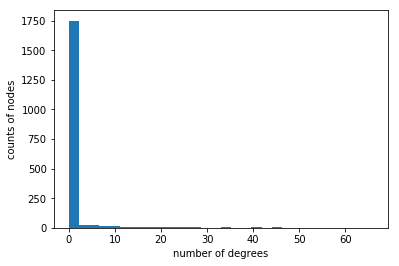

In [ ]:
# plt.hist(miRNAs_nodes_degrees[1].values())
plt.hist(targets_nodes_degrees[0].values(), bins=30)
plt.ylabel('counts of nodes')
plt.xlabel('number of degrees')
plt.show()